In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import json
import re

/data2/shreyas/ENVS/shreydan/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def convert_coco_to_loc_tokens(bbox, img_width, img_height):
    """
    required_token_format: (y_min, x_min, y_max, x_max)
    """
    x_min, y_min, width, height = bbox
    new_x_min = int((x_min/img_width) * 256)
    new_x_max = int(((x_min+width)/img_width) * 256)
    new_y_min = int((y_min/img_height) * 256)
    new_y_max = int(((y_min+height)/img_height) * 256)
    new_bbox = [new_y_min, new_x_min, new_y_max, new_x_max]
    return [f"<loc{val:04d}>" for val in new_bbox]

def convert_loc_tokens_to_bbox(tokens, img_width, img_height):
    norm = lambda c,d : (c/256) * d

    vals = [int(re.search(r"\d+", t).group()) for t in tokens]
    y_min, x_min, y_max, x_max = vals
    y_min, y_max = norm(y_min, img_height), norm(y_max, img_height)
    x_min, x_max = norm(x_min, img_width), norm(x_max, img_width)

    width = x_max - x_min
    height = x_max - x_min
    return [x_min, y_min, width, height]

In [3]:
class CocoCustomVOC(CocoDetection):
    def __init__(self, root, annFile, transform=None, synonyms=None):
        super().__init__(root, annFile)
        self.albumentations_transform = transform
        self.synonyms = synonyms
        self.num_bins = 256

    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        image_np = np.array(image)

        # Extract bboxes + category_ids
        bboxes = [obj['bbox'] for obj in target]
        category_ids = [obj['category_id'] for obj in target]

        # Albumentations requires 'coco' format for input
        if self.albumentations_transform:
            augmented = self.albumentations_transform(
                image=image_np,
                bboxes=bboxes,
                category_ids=category_ids
            )
            image = augmented['image']
            bboxes = augmented['bboxes']
            category_ids = augmented['category_ids']

        chosen_synonyms = {k:random.choice(v) for k,v in self.synonyms.items()}

        # Convert to (ymin, xmin, ymax, xmax)
        targets = []
        width, height = image.shape[1:]
        for i, (box,_id) in enumerate(zip(bboxes, category_ids)):
            tokens = convert_coco_to_loc_tokens(box, width, height)
            targets.append({
                'bbox': box,
                'category_id': _id,
                'category_label': chosen_synonyms[_id],
                'tokens': tokens
            })

        return image, targets

In [4]:
albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Resize(height=640,width=640),
    A.AtLeastOneBBoxRandomCrop(height=512,width=512,erosion_factor=0.2),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'],min_visibility=0.2,min_area=35000))

In [5]:
root_dir = Path('/data2/shreyas/datasets/coco/coco2017')
train_dir = root_dir / 'train2017'
train_anot = root_dir / 'annotations' / 'instances_train2017.json'

In [6]:
from pycocotools.coco import COCO

def get_coco_category_names(ann_file):
    coco = COCO(ann_file)
    cats = coco.loadCats(coco.getCatIds())
    return {cat['id']: cat['name'] for cat in cats}

categories = get_coco_category_names(train_anot)

loading annotations into memory...
Done (t=19.23s)
creating index...
index created!


In [7]:
with open(root_dir/'categories.json') as f:
    category_synonyms = json.load(f)
    category_synonyms = {int(k):v for k,v in category_synonyms.items()}

In [8]:
train_ds = CocoCustomVOC(
    root=train_dir,
    annFile=train_anot,
    transform=albumentations_transform,
    synonyms=category_synonyms
)

loading annotations into memory...
Done (t=12.90s)
creating index...
index created!


In [9]:
def visualize_bbox_comparison(image_array, coco_bbox, tokens, img_width, img_height, title=None):
    """
    Plot original COCO bbox and the one reconstructed from tokens side by side.

    Args:
        image_array: numpy array of the image
        coco_bbox: original COCO format bbox [x_min, y_min, width, height]
        tokens: location tokens tuple (y_min, x_min, y_max, x_max)
        img_width: image width
        img_height: image height
        title: optional title for the plot
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Original bbox in first subplot
    ax1.imshow(image_array)
    ax1.set_title("Original COCO Bbox")
    x, y, w, h = coco_bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)

    # Reconstructed bbox in second subplot
    ax2.imshow(image_array)
    ax2.set_title("Reconstructed from Tokens")
    reconstructed_bbox = convert_loc_tokens_to_bbox(tokens, img_width, img_height)
    x, y, w, h = reconstructed_bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    ax2.add_patch(rect)

    # Add overall title if provided
    if title:
        fig.suptitle(title)

    # Display token values
    token_text = f"Tokens: {tokens}"
    fig.text(0.5, 0.01, token_text, ha='center')

    plt.tight_layout()
    plt.show()

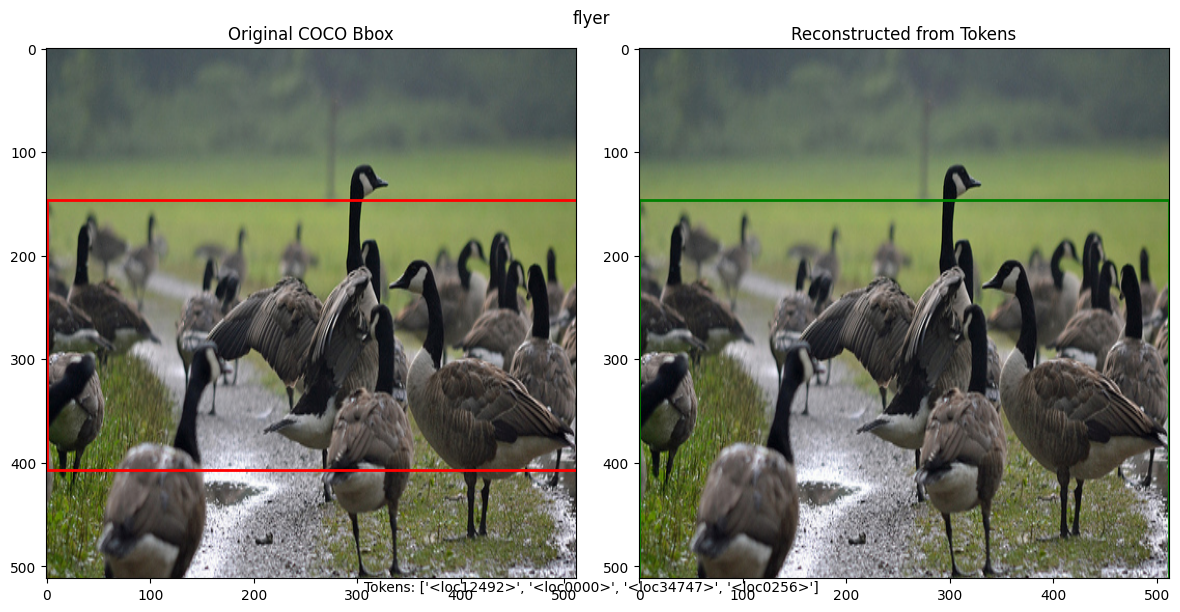

In [10]:
for idx in random.choices(range(len(train_ds)),k=5):
    x=train_ds[idx]
    for bbox in x[1]:
        # visualize_bbox_comparison(image_array, coco_bbox, tokens, img_width, img_height, title=None)
        visualize_bbox_comparison(x[0], bbox['bbox'], bbox['tokens'], x[0].shape[1], x[0].shape[2], title=bbox['category_label'])
        break
    break